In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

In [44]:
df_all = pd.read_csv('ABPICP.csv', delimiter=';', decimal=',', names=['abp', 'icp'] )
df_all

,abp,icp
0,93.14,38.89
1,92.21,39.31
2,91.06,40.25
3,90.59,41.41
4,93.37,42.73
...,...,...
1048571,145.40,44.63
1048572,145.22,44.94
1048573,145.17,44.84
1048574,145.83,44.84


In [45]:
df_all.isna().sum()

abp    0
icp    0
dtype: int64

In [50]:
df = df_all.iloc[:4000]['icp'].values

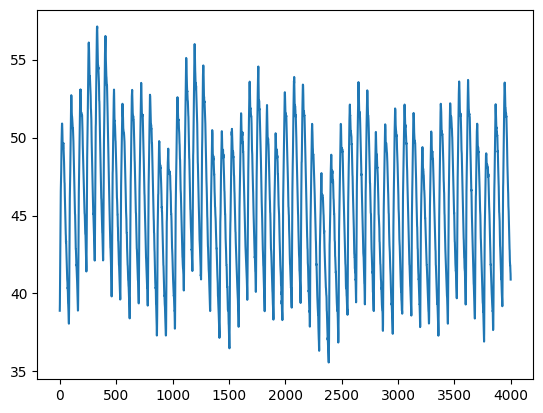

In [51]:
plt.plot(df)

In [52]:
tf.random.set_seed(7)

In [55]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = df.reshape(-1, 1)
dataset = scaler.fit_transform(dataset)

In [96]:
train, test = train_test_split(dataset, test_size=0.2)
print(len(train), len(test))

3200 800


In [57]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [58]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [59]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [60]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3198/3198 - 6s - 2ms/step - loss: 0.0217
Epoch 2/100
3198/3198 - 4s - 1ms/step - loss: 5.1439e-04
Epoch 3/100
3198/3198 - 9s - 3ms/step - loss: 5.0882e-04
Epoch 4/100
3198/3198 - 4s - 1ms/step - loss: 5.0345e-04
Epoch 5/100
3198/3198 - 7s - 2ms/step - loss: 5.0157e-04
Epoch 6/100
3198/3198 - 5s - 2ms/step - loss: 5.0085e-04
Epoch 7/100
3198/3198 - 10s - 3ms/step - loss: 5.0042e-04
Epoch 8/100
3198/3198 - 5s - 1ms/step - loss: 5.0008e-04
Epoch 9/100
3198/3198 - 7s - 2ms/step - loss: 4.9977e-04
Epoch 10/100
3198/3198 - 4s - 1ms/step - loss: 4.9947e-04
Epoch 11/100
3198/3198 - 4s - 1ms/step - loss: 4.9919e-04
Epoch 12/100
3198/3198 - 4s - 1ms/step - loss: 4.9891e-04
Epoch 13/100
3198/3198 - 6s - 2ms/step - loss: 4.9864e-04
Epoch 14/100
3198/3198 - 6s - 2ms/step - loss: 4.9841e-04
Epoch 15/100
3198/3198 - 10s - 3ms/step - loss: 4.9823e-04
Epoch 16/100
3198/3198 - 7s - 2ms/step - loss: 4.9805e-04
Epoch 17/100
3198/3198 - 6s - 2ms/step - loss: 4.9789e-04
Epoch 18/100
3198/3198 - 

In [61]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train Score: 0.46 RMSE
Test Score: 0.45 RMSE


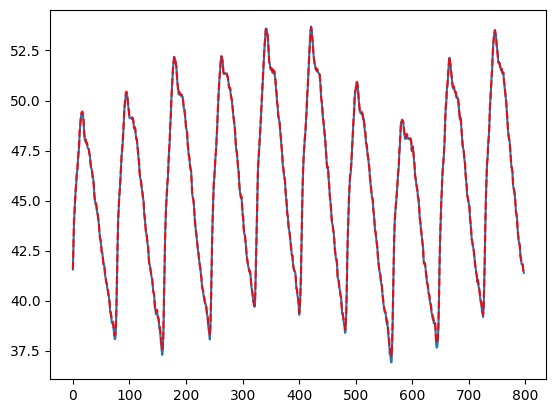

In [72]:
plt.plot(scaler.inverse_transform(testX.reshape(-1, 1)))
plt.plot(testPredict, color='red', alpha=0.9, linestyle='--')

In [74]:
mean_absolute_percentage_error(scaler.inverse_transform(testX.reshape(-1, 1)), testPredict) * 100

0.09858327309656717

In [127]:
def predict_shape(dataset, signal_name, start, end, look_back, model):
  df = dataset.iloc[start:end][signal_name].values
  scaler = MinMaxScaler(feature_range=(0, 1))
  values = df.reshape(-1, 1)
  values = scaler.fit_transform(values)
  train, test = train_test_split(values, test_size=0.2)
  testX, testY = create_dataset(test, look_back)
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  testPredict = model.predict(testX)
  testPredict = scaler.inverse_transform(testPredict)
  plt.plot(scaler.inverse_transform(testX.reshape(-1, 1)))
  print(f'Model absolute prercentage error: {mean_absolute_percentage_error(scaler.inverse_transform(testX.reshape(-1, 1)), testPredict) * 100:.3f}')
  plt.plot(testPredict, color='red', alpha=0.9, linestyle='--')
  

<Axes: >

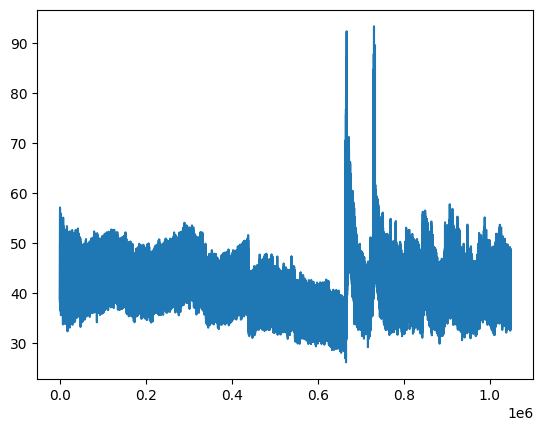

In [128]:
df_all['icp'].plot()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Model absolute prercentage error: 0.104


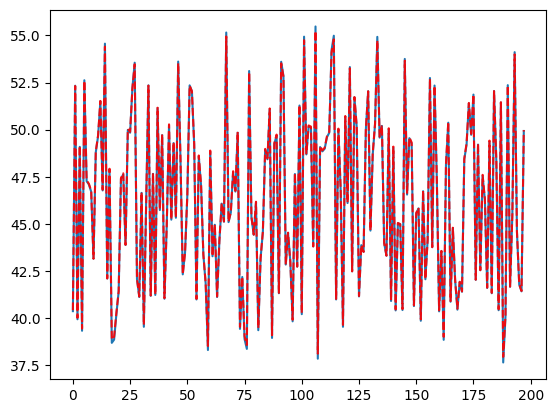

In [134]:
predict_shape(df_all, 'icp', int(0.001 * 1e6), int(0.002 * 1e6), 1, model)